# TFP Probabilistic Layers: Variational Auto Encoder

In this example we show how to fit a Variational Autoencoder using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers

### Load Dataset

In [2]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
test_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))

3.0.0
Using C:\Users\trimu\tensorflow_datasets\mnist\3.0.1 instead.


Dataset mnist downloaded and prepared to C:\Users\trimu\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


위의 _preprocess()는 Keras가 (example, label) 입력 형식 (예 : $p_\theta(y|x)$)을 사용하는 discriminative model 용으로 설정되었기 때문에 `image`가 아닌 `image, image`를 반환합니다. VAE의 목표는 x 자체 (예 : $p_\theta(x|x)$)에서 입력 x를 복구하는 것이므로 데이터 쌍은 (example, example)입니다.

In [3]:
train_dataset, test_dataset

(<ShuffleDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.bool, tf.bool)>,
 <PrefetchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.bool, tf.bool)>)

### VAE Code

#### Specify model.

In [4]:
input_shape = datasets_info.features['image'].shape
base_depth = 32

### Prior - latent representation z 은 isotropic Gaussian (등방성 가우시안 분포) 로 가정 

- Covariance가 identity matrix의 scala 배

In [5]:
encoded_size = 16
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)
prior

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[16] dtype=float32>

## Encoder
인코더 분포의 경우 신경망의 출력으로 매개 변수화된 평균 및 공분산 행렬과 함께 완전 공분산 가우스 분포를 사용합니다. 복잡하게 들릴 수 있지만 TFP 레이어로 표현하는 것은 매우 쉽습니다.  

인코더는 컨볼루션과 Dense 레이어로 구성된 일반적인 Keras Sequential 모델일 뿐 이지만 출력은 TFP 레이어인 MultivariateNormalTril()로 전달되어 최종 Dense() 레이어의 activaton을 mean 과 Multivariate Normal의 parameter인 covariance matrix의 하삼각형을 둘 다 지정하는데 필요한 부분으로 명확히 분할합니다.  `tfpl.MultivariateNormalTriL.params_size(encoded_size)`를 Dense() layer output을 정확히 만들기 위해 사용합니다.

마지막으로 우리는 분포가 최종 손실에 "정규화" 항을 제공해야 한다고 말했습니다. 특히, encoder와 loss 에 대한 prior 사이에 KL Divergence를 추가합니다. ELBO의 KL 항 입니다. 

In [6]:
encoder = tf.keras.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

In [7]:
tfpl.MultivariateNormalTriL.params_size(encoded_size)

152

## Decoder
단순한 `mean-field-decoder`를 사용합니다. 이 경우 pixel-dependent한 Bernoulli 분포 입니다.

In [8]:
decoder = tf.keras.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [11]:
vae = tf.keras.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

## Loss

이미 KL 항이 loss 에 더해졌으므로 reconstruction error 만 지정하면 됩니다. (ELBO 의 첫번째 항)

loss function 은 original input x 와 model 의 output 두개의 인수를 받습니다. random variable이므로 rv_x로 부릅니다. keras와 tensorflow가 TFP layer를 출력 tensor로 보더라도, TFP layer는 실제로는 Distribution object 입니다. 따라서, loss function을 주어진 model에서 data 의 negative log likelihood (-rv_x.log_prob(x))로 만들 수 있습니다. 

In [8]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

_ = vae.fit(train_dataset,
            epochs=15,
            validation_data=test_dataset)

Epoch 1/15
235/235 [==============================] - 31s 38ms/step - loss: 222.6758 - val_loss: 168.0824
Epoch 2/15
235/235 [==============================] - 11s 34ms/step - loss: 156.7697 - val_loss: 150.0564
Epoch 3/15
235/235 [==============================] - 11s 34ms/step - loss: 144.0642 - val_loss: 139.0705
Epoch 4/15
235/235 [==============================] - 10s 33ms/step - loss: 136.9612 - val_loss: 134.2272
Epoch 5/15
235/235 [==============================] - 10s 33ms/step - loss: 132.7587 - val_loss: 131.3123
Epoch 6/15
235/235 [==============================] - 11s 33ms/step - loss: 130.2923 - val_loss: 128.6432
Epoch 7/15
235/235 [==============================] - 11s 33ms/step - loss: 127.9989 - val_loss: 125.7906
Epoch 8/15
235/235 [==============================] - 11s 34ms/step - loss: 125.2917 - val_loss: 123.4333
Epoch 9/15
235/235 [==============================] - 11s 34ms/step - loss: 123.2896 - val_loss: 121.3037
Epoch 10/15
235/235 [=========================

## original image 를 vae network 을 통과시켜 얻은 distribution object 로 image sampling

In [19]:
# We'll just examine 10 random digits.
x = next(iter(test_dataset))[0][:10]
xhat = vae(x)
print(x.shape)
assert isinstance(xhat, tfd.Distribution)
print(xhat)

(10, 28, 28, 1)
tfp.distributions.Independent("model_sequential_1_independent_bernoulli_IndependentBernoulli_Independentmodel_sequential_1_independent_bernoulli_IndependentBernoulli_Bernoulli", batch_shape=[10], event_shape=[28, 28, 1], dtype=float32)


In [14]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

In [22]:
xhat.sample().shape, xhat.mode().shape, xhat.mean().shape

(TensorShape([10, 28, 28, 1]),
 TensorShape([10, 28, 28, 1]),
 TensorShape([10, 28, 28, 1]))

Originals:


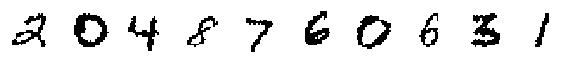

Decoded Random Samples:


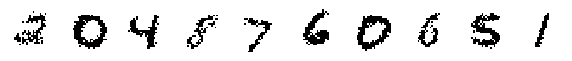

Decoded Modes:


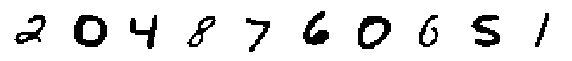

Decoded Means:


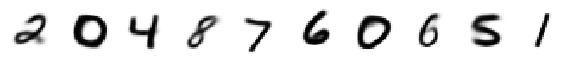

In [15]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

## original image 가 아니라 prior 에서 sampling 한 latent variable 로 image 생성

In [25]:
z = prior.sample(10)
xtilde = decoder(z)
print(xtilde)
assert isinstance(xtilde, tfd.Distribution)

tfp.distributions.Independent("sequential_1_independent_bernoulli_IndependentBernoulli_Independentsequential_1_independent_bernoulli_IndependentBernoulli_Bernoulli", batch_shape=[10], event_shape=[28, 28, 1], dtype=float32)


Randomly Generated Samples:


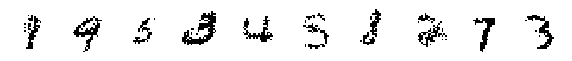

Randomly Generated Modes:


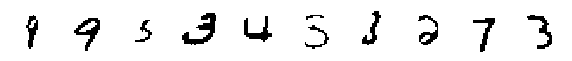

Randomly Generated Means:


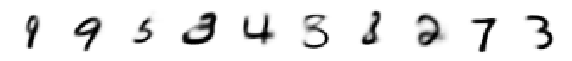

In [26]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

### plot latent variable

In [30]:
z = encoder(x)

In [34]:
latent = z.sample()
latent.shape

TensorShape([10, 16])

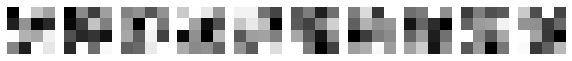

In [41]:
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
plt.ioff()
for i in range(10):
    axs.flat[i].imshow(latent[i].numpy().reshape(4, 4), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
plt.show()